<a href="https://colab.research.google.com/github/2IS239-Data-Analytics/laboration_3-grupp-5/blob/master/Inl%C3%A4mning_Laboration3_del2_klassificering_VT21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboration 3 del 2 klassificiering

## Klassificering

I denna andra del ska ni testa att klassificera ett annat dataset med hjälp av två olika modeller för klassificering, logistiskt regression och desicion trees (som klarar såväl regression som klassificering). Vi kommer använda ett dataset som har data om överlevare från Titanic.

Det dataset vi ska använda finns i datamappen på GitHub och heter Titanic. Några av de bibliotek ni behöver för att komma igång är också importerade i nedan kod. 

Den del av laboration som handlar om decision trees är inspirerad av David Johnsson på Uppsala universitet.


### Logistisk regression för att bestämma om man överlever eller inte

De frågor som ska besvaras är märkta med **Q** medan coduppgifter är märkta med **C**.

I vissa fall finns flera delfrågor som kan innehålla både rena koduppgifter, frågor eller en kombination, dessa är märkta **QC**. Delfrågorna Dessa är i en lista med en bokstav framför, ex. a. Huruvida en deluppgift ska kodas eller enbart besvaras avgörs av er baserat på själva texten. När ni arbetar med uppgiften förväntas ni själva avgöra hur många kodblock som krävs för att kunna utföra uppgiften samt göra den tydlig och lätt att förstå. Samma sak gäller när ni kommenterar och besvarar frågor, skriv kortfattat men tydligt. **(OBS! Vissa uppgifter kräver flera kodblock, då behöver ni skapa dem!)**

**Exempel:**

**QC** Undersök hur många som levde och hur många som dog.

>a. Antal som överlevde och antal som dog?
>
>b. Hur många % överlevde?
>
>c. Visualisera antal överlevare och antal döda i ett stapeldiagram

In [77]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

**C** Läs in datafilen och gör dig familiär med den. 

In [78]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [79]:
#Mounting gDrive in Colaboratory
try:
    from google.colab import drive
    drive.mount("/content/drive/", force_remount=True)
    google_drive_prefix = "/content/drive/My Drive"
    data_prefix = "{}/mnist/".format(google_drive_prefix)
except ModuleNotFoundError: 
    data_prefix = "data/"

Mounted at /content/drive/


In [80]:
# Import our Titanic Data and store it in the variable tc_df 
tc_df= pd.read_csv("/content/drive/MyDrive/titanic-train.csv", delimiter=",")
# Display the data in the notebook
tc_df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [81]:
# Checking datatypes in dataframe
print(f'{tc_df.dtypes} \n')

# Checking if there's any null value for passengerID
print(f'Nullpassangers: {tc_df.isnull().PassengerId.any()} \n')

# Displaying all null values for dataframe by column
print(tc_df.isnull().sum()) 

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object 

Nullpassangers: False 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


**Q** Nedan är en översikt över några kolumner - fyll i vad varje kolumn står för där information saknas

- `survival` - Överlevde ja/nej - 1/0
- `pclass` - Passagerarklass
- `sex` - Kön
- `age`- Ålder
- `sibsp` - # av syskon/äkta hälft ombord 
- `parch` - # av föräldrar/barn ombord 
- `ticket` - Biljettnr/typ
- `fare` - Biljettpris
- `cabin` - Hyttnr
- `embarked` - Hamn där man steg ombord (C = Cherbourg, Q = Queenstown, S = Southampton)

**Q** Hur många passagerare fanns på Titanic enligt ert dataset?

In [82]:
# 891 rows - 891 passengers
print(f'Amount of passengers: \t {len(tc_df)}')

Amount of passengers: 	 891


### Explorativ dataanalys

För att veta vilka data som har betydelse när det handlar om att klassificera huruvida en person lever eller dör behöver vi undersöka vårt dataset med fokus på vilka variabler som påverkar `survival` som är den beroende variabel vi vill prediktera, allts vårt y. Först behöver vi dock städa och förbereda data för analys.

**QC** Undersök hur många som levde och hur många som dog.

a. Antal som överlevde och antal som dog?
> **Svar:** 342 överlevde och 549 dog. 

b. Hur många % överlevde?
>**Svar:** 38% Överlevde

>c. Visualisera antal överlevare och antal döda i ett stapeldiagram

In [83]:
# a.
# print amount of deaths and survivals
total_amount = tc_df.Survived.value_counts() 
print(f'Omkomna:\t{total_amount[0]} \nÖverlevde:\t{total_amount[1]}')

Omkomna:	549 
Överlevde:	342


In [84]:
# b.
# Using value_counts again but with normalize true, which returns the percentage. Also formats with .format to whole number.
print("Överlevde: ","{:.0%}".format(tc_df.Survived.value_counts(normalize=True)[1]))

Överlevde:  38%


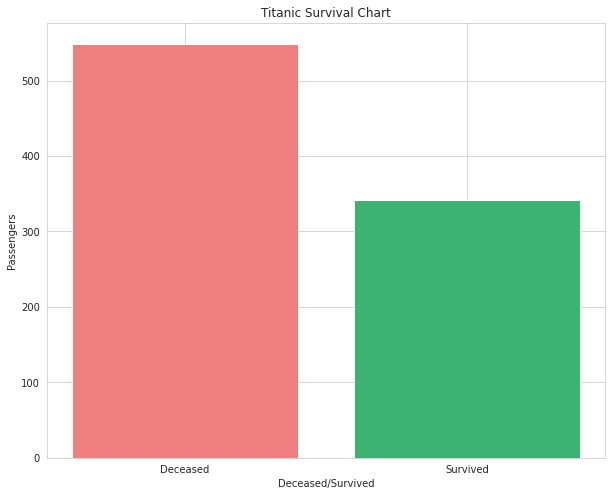

In [85]:
# c 
deceased = total_amount[0]
survived = total_amount[1]

dataset = {'Deceased': deceased, 'Survived':survived} 
keys = list(dataset.keys()) 
values = list(dataset.values()) 
   
plt.bar(keys, values, color =['lightcoral', 'mediumseagreen']) 
  
plt.xlabel("Deceased/Survived") 
plt.ylabel("Passengers") 
plt.title("Titanic Survival Chart") 
plt.show() 

**QC** Städa ert data, hantera nullvärden, kontrollera outliers, typ av variabler (kategoriska, kontinuerliga, numeriska/labels)

>
>a. Vilka kolumner har nullvärden?

> **Svar:** Age. Cabin och Embarked.

b. Hur kan dessa hanteras? 
>**Svar:** Age bör troligtvis ersättas mot medianen. Att ta bort 177 rader är en ganska stor del av datat. Cabin kolumnen kan nog tas bort då vi redan har andra detaljer som förklarar passagerares ekonomiska status och att ersätta 687 rader mot ett annat värde är inte rimligt när det är större delen av datat.

>c.Vilken typ av nullvärden har ni (MCAR/MAR/NMAR)?

>**Svar:** Cabin är möjligtvis NMAR då det kanske kan bero på att vissa hytter i t.ex. lägre klass var "valfria" eller att endast en person i sällskapet står på hytten. Age skulle kunna vara MAR att det rör sig om något inläsnings fel eller liknande. Det kan även röra sig om att det varit valfritt att ange ålder för barn eller något i den stilen. Embarked är troligtvis MCAR då det endast är så få värden som saknas. 

>d. Vilka risker finns med ert sätt att hantera nullvärden? Varför? 

> **Svar:** Att ta bort Cabin gör att man kan missa vissa slutsatser. Det går inte att säga vilken hytttyp som t.ex. hade högst överlevnad samt om hyttypen kan kopplas till en viss passagerarklass. Att ändra null åldern till medianen kan göra att t.ex. medelåldern/median för hela kolumnen påverkas markant. Att ta bort de två raderna med Embarked gör att vi missar två rader med data men det bör inte påverka särskilt mycket i sin helhet (om det inte rör sig om extrema outliers). 

>e.Finns det outliers? Behöver de hanteras?

> **Svar:** Vi har outliers i bland annat Age, SbiSp och Fare. Dessa ska eventuellt behandlas. 

>f.Vilka variabler är kategoriska och vilka är kontinuerliga?
>
**Svar:**

- `survival` - Kategorisk
- `pclass` - Kategorisk
- `sex` - Kategorisk
- `age`- Kontinuerlig
- `sibsp` - Kontinuerlig
- `parch` - Kontinuerlig
- `ticket` - Kontinuerlig
- `fare` - Kontinuerlig
- `cabin` - Kategorisk
- `embarked` - Kategorisk

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


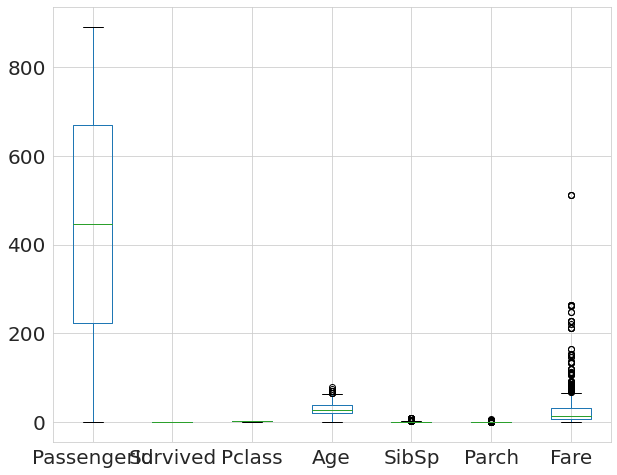

In [86]:
# Using pandas built in boxplot to view outliers
tc_df.boxplot(fontsize=20) 

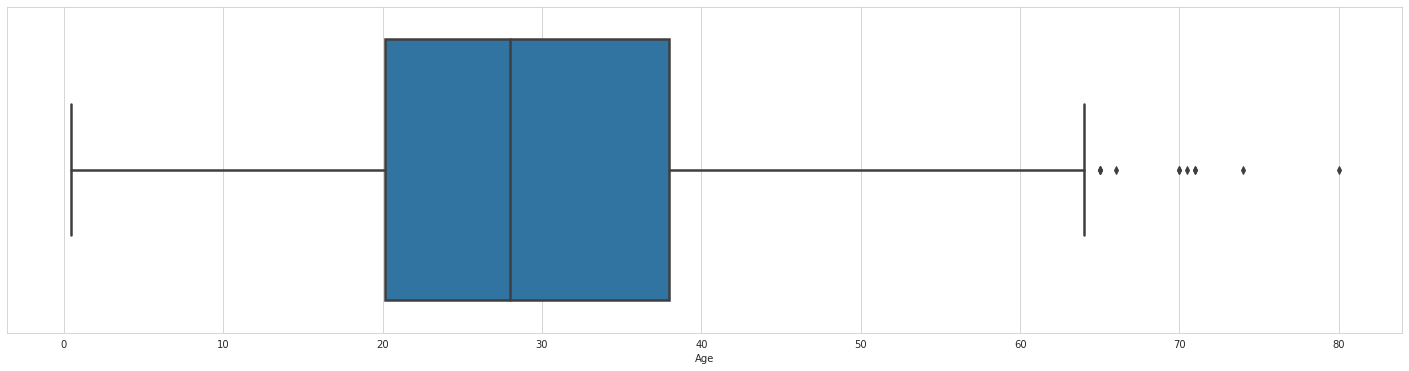

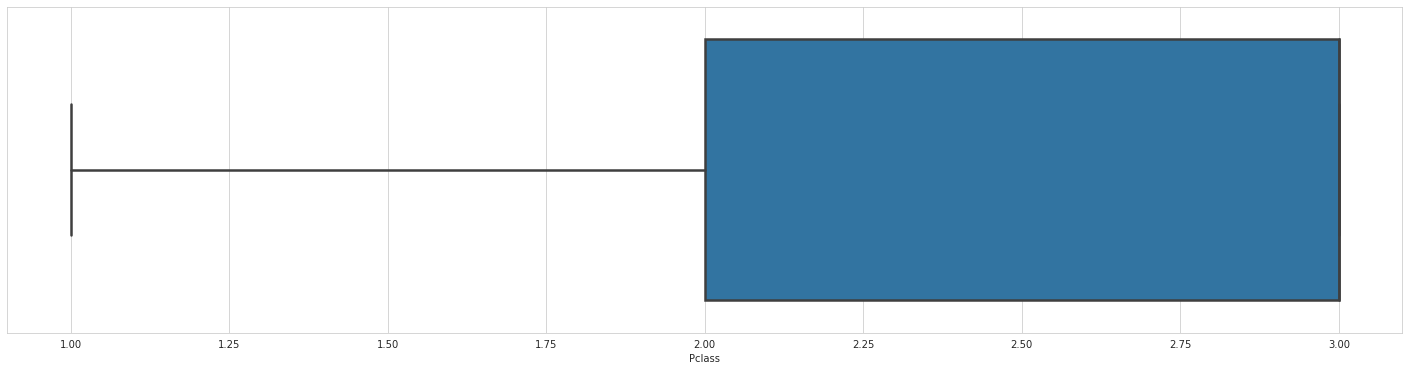

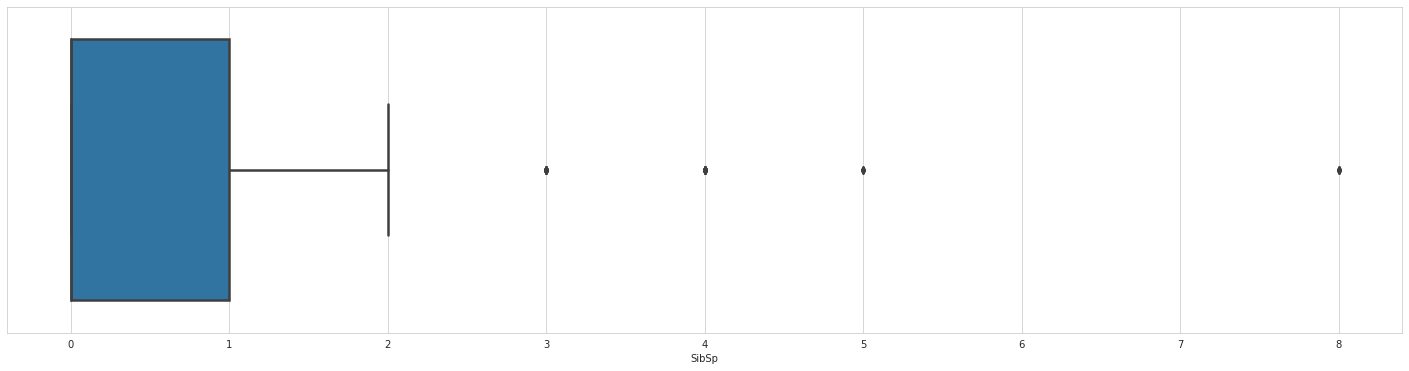

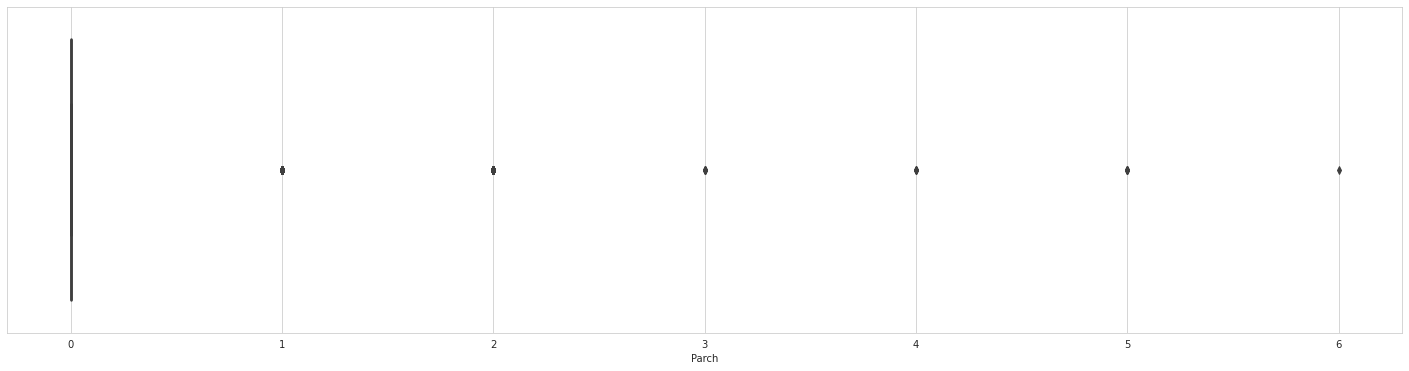

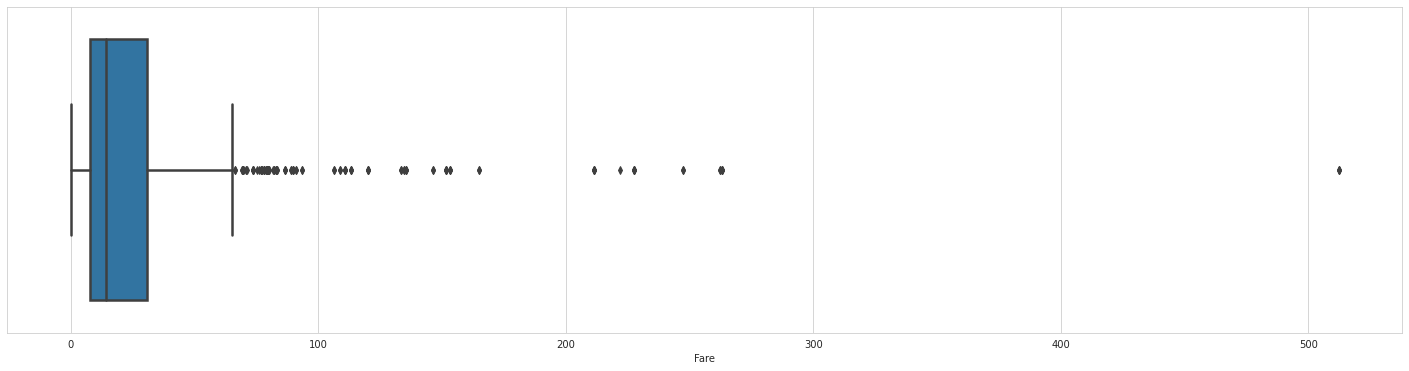

In [87]:
# Function for plotting outliers 
def plot_outlier(feature):
  plt.figure(figsize=(25, 6))
  ax = sb.boxplot(x=feature, linewidth=2.5)

# plot outliers
plot_outlier(tc_df['Age'])
plot_outlier(tc_df['Pclass'])
plot_outlier(tc_df['SibSp'])
plot_outlier(tc_df['Parch'])
plot_outlier(tc_df['Fare'])

I följande uppgifter ska ni testa två olika varianter för att ersätta null och jämföra dessa med varandra samt välja den bästa för ert syfte. 

**C** Ersätt null med medianåldern
**OBS!** Kom ihåg att du måste spara dina ändringar i en ny dataframe, det går inte att ta bort null två gånger ur samma dataframe. 


In [88]:
#Ersätt ålder med medianåldern
# Creating a new dataframe by copying the first one. 
titanic_passenger_fill_null_median = tc_df.copy()
# Using fillna to fill null values with Age median
titanic_passenger_fill_null_median.Age.fillna(value=titanic_passenger_fill_null_median.Age.median(), inplace=True)

titanic_passenger_fill_null_median.head(10) 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


**CQ** Ersätt null med lämpliga värden baserat på andra variabler i ert dataset.

>a. För att beräkna korrelationen mellan olika variabler i ett dataset kan vi använda pandas inbyggda `corr()`. I nedan kodcell kontrolleras samtliga variabler gentemot varandra.
>
>b. Varför är det 1.00000 i flera rader?

>**Svar:** För att attributet jämförs mot sig själv i matrisen.

>c. Vilka kolumner har någon korrelation med varandra? 
>HINT! En rule of thumb kan sägas vara att varaibler är svagt korrelerande om korrelationskoefficienten (r) är mellan 0,2-0,39, medelkorrelerade >mellan 0,4-0,59, och starkt korrelerade mellan 0,6-0,79, över 0,8 är mycket stark korrelation och 1 är helt beroende variabler. 

>**Svar:** Negativ svag korrelation mellan survived och klass. Negativ svag mellan ålder och klass. Negativ svag relation mellan ålder och antal syskon/äkta hälft ombord. Positiv stark korrelation mellan # av syskon/äkta hälft ombord och # av föräldrar/barn ombord .

>d.Den starkaste korrelationen finns mellan ålder och klass. Vilken typ av korrelation är det (negativ eller positiv) och hur stark?
>**Svar:** Negativ svag korrelation -0.369226

>e.I cellen under korrelationsberäkningen görs en visualisering av ålder i relation till klass. Vad säger den?

>**Svar:** Generellt kan man säga att ju yngre person desto lägre klass färdades personen i (finns dock outliers).

>f.Ersätt nullvärdena i age baserat på vad du kom fram till i fråga e. 
>
>

In [89]:
#Ersätt med relevant ålder beroende på korrelerad variabel
tc_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


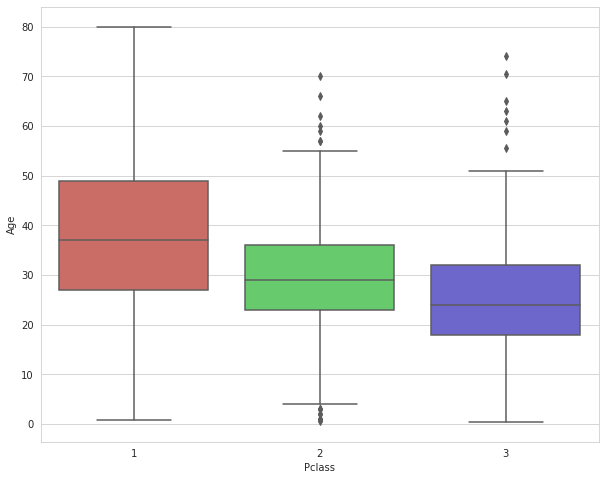

In [90]:
sb.boxplot(x='Pclass', y='Age', data=tc_df, palette='hls')

In [91]:
print(tc_df.Age.describe())
print(titanic_passenger_fill_null_median.Age.describe())

 # replace null values for Age, based on the Pclass group and median of that Pclass
tc_df['Age'] = tc_df['Age'].fillna(tc_df.groupby('Pclass')['Age'].transform('median'))

print(tc_df.Age.describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64
count    891.000000
mean      29.066409
std       13.244532
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64


**Q** Vilket sätt är att föredra?
(HINT! kontrollera de vanliga mätvärdena du får med `.describe()` för ert dataset innan och efter ni ersätter nullvärden, dessa bör vara ungefär samma före som efter ex. median/medel/max/min)

**Svar:** Vi anser att det andra alternativet där nullvärden ersätts med medianen av respektive Pclass är mer lämplig. Den förändrar inte median, medelvärde eller max/min på ett drastiskt sätt men gör att datan ökar och att vi kan utvinna en bättre modell. Att ta median efter klass ger en mer verklig bild av läget. Däremot bör det tilläggas att ersätta med Age's median ger ett värde närmare den ursprungliga medianen.

**QC** Det finns en till kolumn med nullvärden 

>a.Vad är lämpligt att göra med den?

>**Svar:** Ta bort kolumn (Cabin) / rader (Embarked)

>b.Gör det :)

In [92]:
#Handling Cabin
tc_df.drop('Cabin', axis=1, inplace=True)

# Handling embarked
tc_df.drop(tc_df[tc_df.Embarked.isnull()].index, axis = 0, inplace=True)

**QC** Analys av varaibler

Nu har vi städat vårt dataset är det dags att förbereda det för analys. 

a. Vilka variabler är överhuvudtaget inte intressanta för huruvida man lever eller dör? Kontrollera i vår korrelationsanalys.(OBS! Alla kolumner finns inte med eftersom det inte går att beräkna korrelation på vissa)
>Svar: Variabler som inte är intressanta för oss är: PassengerId, Name, Fare, Ticket, Embarked och SibSp. 

b.När vi använder logistisk regression vill vi inte att de oberoende variablerna ska vara för korrelerade (beroende) av varandra. Det påverkar resultatet negativt. Därför tittar vi igen på vår korrelationsanalys. För att vi ska tycka korrelationen är för stark bör gränsvärdet ligga runt 0,4, rensa bland era variabler så att det inte finns några oberoende variabler som har en korrelation starkare än 0,4 till någon av de andra oberoende variablerna.
>


In [93]:
# this function can be used to print highly correlated values in order, without perfectly correlated values (1.00...)
def print_highly_corr(corr_values):
  sorted_mat = corr_values.unstack().sort_values(ascending=False) # get a sorted matrix for correlation values 
  sorted_mat = sorted_mat[sorted_mat != 1.0] # drop 1.00... values
  sorted_mat = sorted_mat[sorted_mat > 0.4] # drop values < 0.4
  print(sorted_mat) # print the sorted matrix

print_highly_corr(tc_df.corr().abs()) # print highly correlated values in order

Pclass  Fare      0.548193
Fare    Pclass    0.548193
SibSp   Parch     0.414542
Parch   SibSp     0.414542
Pclass  Age       0.405549
Age     Pclass    0.405549
dtype: float64


In [94]:
titanic_passengers = tc_df.copy() # we will use this later...

In [95]:
# Vi kan se att Fare och Pclass har för hög korrelation, 0,54. Age och Pcclass ligger runt 0,4 så här är det eventuellt möjligt att behålla båda om det är av intresse.
# SibSp och Parch har 0.41 vilket vi anser väl passerar gränsen på 0,4. 
# print correlation for dataframe
tc_df.corr()

# Removing unneccessary columns
tc_df.drop(columns=['PassengerId','Name','Ticket'], inplace =True)
# Removing columns with to high correlation.
tc_df.drop(columns=['Fare','SibSp'], inplace =True)
# print correlation again 
tc_df.corr()

,Survived,Pclass,Age,Parch
Survived,1.000000,-0.335549,-0.052051,0.083151
Pclass,-0.335549,1.000000,-0.405549,0.016824
Age,-0.052051,-0.405549,1.000000,-0.170089
Parch,0.083151,0.016824,-0.170089,1.000000


**QC** Se till att variablerna går att applicera i vald modell.

Eftersom vi ska använda logistisk regression måste alla värden vara numeriska, vi behöver alltså ändra våra kategoriska, icke-numeriska variabler till numeriska. Detta görs lämpligen genom ungefär följande kod: `dataframe_without_kategorial_sex = pd.get_dummies(*namnet på ddataframen*, columns=['Sex'], drop_first=True)`

>
>a. Varför ersätter vi med 0 och 1 istället för 0,1,2,3?
>
>b. Ersätt övriga kategoriska kolumner med dummyvariabler. 
>
>

In [96]:
tc_df_without_categorical_sex = pd.get_dummies(tc_df, columns=['Sex'], drop_first=True)

In [97]:
#9b: Gör samma sak för övriga kategoriska variabler
tc_df_without_categorical_sex = pd.get_dummies(tc_df_without_categorical_sex, columns=['Embarked'], drop_first=True)
tc_df_without_categorical_sex.head(10)

,Survived,Pclass,Age,Parch,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,0,1,0,1
1,1,1,38.0,0,0,0,0
2,1,3,26.0,0,0,0,1
3,1,1,35.0,0,0,0,1
4,0,3,35.0,0,1,0,1
5,0,3,24.0,0,1,1,0
6,0,1,54.0,0,1,0,1
7,0,3,2.0,1,1,0,1
8,1,3,27.0,2,0,0,1
9,1,2,14.0,0,0,0,0


**QC** Skapa modell, träna och testa (här behöver ni själva skapa ett antal kodblock för de olika deluppgifterna.)

(OBS! Se till att ni döper era variabler till X-train, X_test,y_train,y_test annars fungerar inte utvärderingskoden)

>
>a. Starta med att formatera data så att du skapar X och y där y är den beroende variabeln survival och X är samtliga beroende variabler (de som ni bestämt er för att ha kvar i ert dataset)
>
>b. Dela i träning (80%) och test (20%)
>
>c. Har vi tillräckligt med data för att kunna träna vår modell eller måste vi ta bort fler kolumner? HINT! en rule of thumb säger minst 50 rader per oberoende variabel.

>**Svar:** Ja vi har tillräckligt med data. 711 per oberoende variabel.

>d.Skapa och träna modell (kod finns för starten)
>
>e.Testa modell på träningsdata
>
>f. Vad är sannolikheten för att en kvinna, ålder 34, med två barn som reser i 2:a klass med sin man överlever? 

>**Svar:** Prediktionen säger att hon överlever. Sannolikheten är ca 76%.


In [98]:
# a
X = tc_df_without_categorical_sex[['Age', 'Sex_male', 'Embarked_Q', 'Embarked_S','Parch', 'Pclass']]
y = tc_df_without_categorical_sex['Survived']

In [99]:
# b 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 
# c
# 711 rows per X_train column
print(len(X_train.Age))
print(len(X_train.Sex_male))
print(len(X_train.Embarked_Q))
print(len(X_train.Embarked_S))
print(len(X_train.Parch))
print(len(X_train.Pclass))
print("Our training data has {} rows".format(len(X_train)))
print("Our test data has {} rows".format(len(X_test)))

711
711
711
711
711
711
Our training data has 711 rows
Our test data has 178 rows


In [100]:
#Startkod för uppgift d) skapa och träna modell
log_reg = LogisticRegression() 
# train data,
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
#e test model 
y_pred = log_reg.predict(X_test)

# print classification report
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(log_reg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.79
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       109
           1       0.71      0.78      0.74        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.80      0.79      0.79       178



In [102]:
# X with female age 34 with a husband, and two children. 
custom_X_data = {'Age': 34, "Sex_male": 0, 'Embarked_Q': 0, 'Embarked_S': 0, 'Parch':3, 'Pclass': 2} # another version if we still have Parch as value 

temp_df = pd.DataFrame(custom_X_data, index=[0])
np_X = temp_df.to_numpy().reshape(1, -1)
print(np_X)
# use the model to predict outcome
custom_y_pred = log_reg.predict(np_X)
# use model to predict probability 
y_prob = log_reg.predict_proba(np_X)
# print outcome and probability
print(f'Survived: {custom_y_pred[0]}')
print(f'Probability to die: {round(y_prob[0][0]*100, 2)}\nProbability to live: {round(y_prob[0][1]*100, 2)}')

[[34  0  0  0  3  2]]
Survived: 1
Probability to die: 24.05
Probability to live: 75.95


**QC** Utvärdera modell

I nedanstående kodblock utvärderas klassificeringsmodellen på några olika sätt. 

>
>a. Vilka sätt att utvärdera en klassificeringsmodell är kodade nedan?

>**Svar:** Confusion matrix och Classification report. Confusion matrix är en utvärdering där output kan vara två eller flera klasser. Confusion matrix skapar en matris med fyra kombinationer av förutspådda värden och faktiska värden.
Classification report återger följande viktiga mått i ett klassificeringsproblem:

*   Precision är mätning av klassificeringsalgoritmens exakthet.
*   Recall mäter klassificerarens kompletthet, vilket innebär dess förmåga att korrekt hitta samtliga positiva instanser. 
*   F1 score mäter precision och recall på en skala där 1.0 är bästa resultatet och 0.0 är det sämsta. F1 score bör användas för att jämföra klassificeringsmodeller, inte för att mäta global noggrannhet.
*   Support mäter antalet förekomster av en viss klass i ens dataset. En dålig balans i träningsdata kan betyda att det finns en strukturell svaghet i de rapporterade mätningarna, man kan då behöva se över
balanseringen och ens provtagning.

>b. För varje utvärderingsmetod som är kodad (Confusion matrix  och Classification report), vad säger de om den klassificerare ni tränat? 

> **Svar:** Confusion Matrix säger att vi har förutspått 87 sanna positiva, 22 falska positiva, 15 falska negativa, samt 54 sanna negativa värden. Weighted avg för mätvärdena ligger mellan 0.79-0.80. Klassificeringsrapporten återger liknande resultat fast procentuellt, där F1 score ger en bra sammanfattande bild på precision och recall. 

>c. Vad är er bedömning av er klassificerare (bra/dålig) vad baserar ni detta på och varför? 

>**Svar:** Vi anser att klassificeraren är ganska bra. Utvärderingsmetoderna visar att klassificeraren är relativt tillförlitlig, där majoriteten av svaren blir sanna positiva/negativa framför tvärtom. Vi anser att den är bra med tanke på datamängden, samt osäkerheten i det vi försöker förutspå. Eftersom det inte finns någon självklar väg att ta i förutsägelsen så anser vi att modellen fungerar bra så länge den kan producera trovärdiga resultat baserat på enskilda tester (som vi provade med kvinna i ålder 34...), men också riktiga testdata, vilket den gör. 

In [103]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[87, 22],
       [15, 54]])

Text(0.5, 510.88, 'Predicted label')

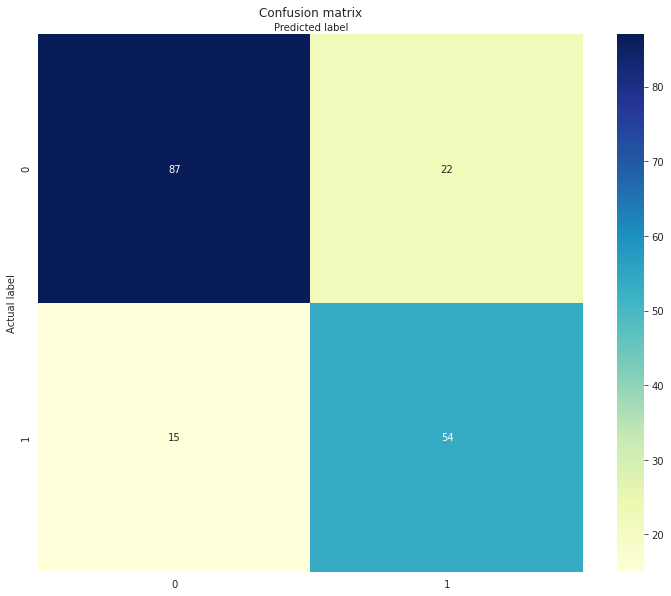

In [104]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sb.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       109
           1       0.71      0.78      0.74        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.80      0.79      0.79       178



### Desicion trees för att bestämma vilka som överlever

Vi ska också testa att använda ett beslutsträd för att bestämma vilka som överlever. Koden för detta är redan given nedan. Dock ska ni besvara några frågor kring beslutsträd och jämföra resultatet mellan de två klassificerarna. 

**QC** Följande frågor ska besvaras, vissa kan kräva att ni skriver kod. Ni ska också (kortfattat) kommentera koden så att det framgår vad som görs.

>
>a. Vilka oberoende variabler (features) används i beslutsträdet för att avgöra vem som överlever?

>**Svar:** Sex_male, SibSp, Age, Fare används som variabler i beslutsträdet. 

>b.Hur många män respektive kvinnor överlever i prediktionen om du testar att prediktera med endast de 10 första raderna som sample (OBS! Kräver kod)

>**Svar:** Efter att ha provkört koden ett par gånger så varierar resultatet lite, men det tycks alltid vara flest kvinnor som överlever. Exempel på några resultat:
*   3 kvinnor överlever, 0 män
*   5 kvinnor överlever, 0 män
*   3 kvinnor överlever, 1 man

>c. Hur många felaktiga respektive korrekta prediktioner gör beslutsträdet i jämförelse med den logistiska regressionen?

>**Svar:** 

*   117 sanna positiva (87%), 18 falska positiva, 23 falska negativa, 65 sanna negativa (74%) för beslutsträdet. 
*   Logistiska regressionen fick: 88 sanna positiva (84%), 17 falska positiva, 19 falska negativa, samt 55 sanna negativa värden (74%). 


>d. Vilken av algoritmerna är "bäst? för uppgiften?

>**Svar:** Beslutsträdet får varierande resultat varje gång man kör koden, vilket tyder på viss opålitlighet i algoritmen. Resultaten för accuracy, recall och f1-score blir dock väldigt likt det vi fick för logistisk regression. 
Vi anser att logistisk regression är bättre för uppgiften delvis för att variablerna som används medför en del "data noise" som beslutsträd är sårbara för. Beslutsträdet kan lätt "overfitta" vår data - Overfitting handlar om att ha omedvetet extraherat en del av data noise, dvs. den oförklarliga variansfraktionen i ens data, som om den variationen representerade en underliggande modellstruktur.

>Eftersom tre av de avgörande variabelerna är ålder, SibSp och Fare och att dessa är kontinuerliga så passar också Logistisk regression. Kategorisk data fungerar generellt bättre i beslutsträd, medan kontinuerlig data fungerar väl med logistisk regression. 

>Två argument för beslutsträdet är att könet är den mest avgörande variabeln och denna är kategorisk, samt att denna algoritm är bra på att hantera outliers. Man kan anse att det finns många outliers i ålder-variabeln, men styrkorna hos logistisk regression överväger styrkorna för beslutsträd, anser vi.

>e. Vilka svagheter respektive styrkor har de båda modellerna i jämförelse med varandra?

>**Svar:** Logistisk regression söker efter linjära beslutsgränser, medan ett beslutsträd delar upp och använder sig av axeljusterade linjära beslutsgränser. Beslutsträd är därför bra när ens datapunkter inte lätt
separeras av ett "hyperplan". När klasser inte är separerade på ett bra sätt blir beslutsträd lätt sårbara för overfitting av träningsdatan. I dessa fall kan logistisk regressions mer linjära gräns 
generalisera på ett lämpligare sätt. Det går att bekämpa overfitting för beslutsträd genom att använda sig av "pruning". 

>Beslutsträd är lättare att tolka och kan även användas på mindre dataset. Nackdelarna är att de är mer sårbara för overfitting och "data noise". 
Logistisk regression är mer robust mot data noise och overfitting, men kräver en större mängd data. 


>f.Hur har beslutsträdet "tänkt" för att komma fram till modellen?

>**Svar:** Beslutsträdet delas in i klasserna Alive (blå) och Dead (orange). Baserat på variablernas värden så kan utfallet antingen gå vidare till den blå eller orangea klassen för Survived. 
Beslutsträdet utgår från de olika korrelationerna och har kommit fram till att det mest avgörande (toppen av trädet) är könet, därefter avgör den om SibSp är <= 2.5 och om den är det så avgör den också om Fare är <= 36.688, annars ifall SibSp är > 2.5 så kontrollerar den ifall Fare är <= 21.038. 
Andra "sidan" av trädet utgår från könet och sedan utifrån om Age är <= 6.5, om det är fallet så kollar den om SibSp är <= 2.5, om Age är > 6.5 så kontrollerar den om Fare är <= 26.269. 
>


In [106]:
from graphviz import Source 
from sklearn.tree import export_graphviz 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 

In [107]:
survived_data = titanic_passengers.Survived #detta motsvarar y
titanic_passengers = pd.get_dummies(titanic_passengers, columns=['Sex'], drop_first=True) # turn sex column into dummies for this dataframe 
titanic_passengers = titanic_passengers[['Sex_male', 'Fare', 'Age', 'SibSp']] #motsvarar X
titanic_passengers.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex_male  889 non-null    uint8  
 1   Fare      889 non-null    float64
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
dtypes: float64(2), int64(1), uint8(1)
memory usage: 28.6 KB


In [108]:
X_train, X_test, y_train, y_test = train_test_split(titanic_passengers, survived_data, test_size=0.25)
print("Our training data has {} rows".format(len(X_train)))
print("Our test data has {} rows".format(len(X_test)))

Our training data has 666 rows
Our test data has 223 rows


In [109]:
# Importing DecisionTreeClassificer, othweise get's error message
from sklearn.tree import DecisionTreeClassifier 
# Creating DecisionTreeClassifier with 3 as max depth (which means we get 3 levels of siblings/nodes/branches below the top)
classifier = DecisionTreeClassifier(max_depth=3)
# Fit's the decision tree with training values
classifier.fit(X_train.values, y_train.values)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [110]:
# Predicts y
y_pred = classifier.predict(X_test.values)

In [111]:
# Creating Confusion Matrix for the model
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test.values, y_pred)
confusion_matrix

array([[121,  15],
       [ 25,  62]])

In [112]:
# Classification report for the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       136
           1       0.81      0.71      0.76        87

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



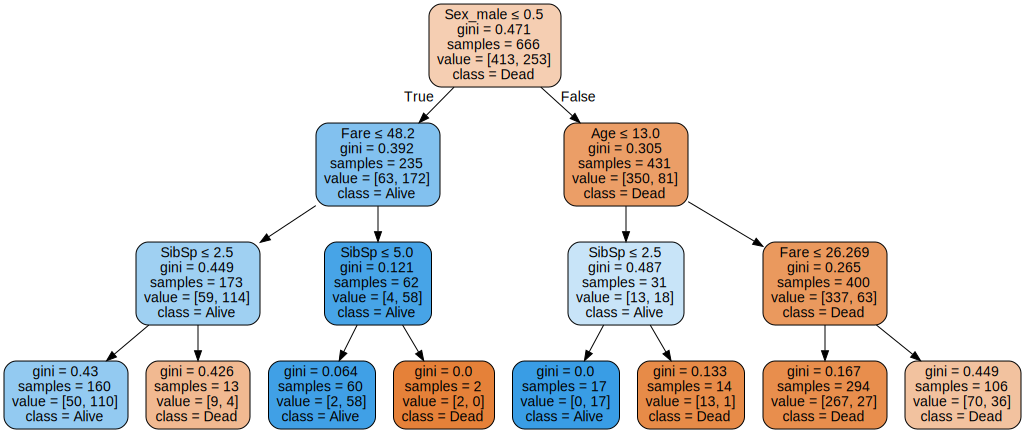

In [113]:
tree_plot = Source(tree.export_graphviz(classifier, out_file=None, 
                            feature_names=X_train.columns, class_names=['Dead', 'Alive'], 
                            filled=True, rounded=True, special_characters=True))
tree_plot

In [114]:
# b.
ten_sample = X_test.head(10) # get 10 sample passengers
ten_sample['Survived'] = classifier.predict(ten_sample) # predict the sample 
ten_sample

ten_sample.groupby('Sex_male')['Survived'].value_counts() # show grouped outcome of predicted data
print(f'Amount of females that survived: {ten_sample.groupby("Sex_male")["Survived"].sum().loc[0]}, amount of males that survived {ten_sample.groupby("Sex_male")["Survived"].sum().loc[1]}')

Amount of females that survived: 5, amount of males that survived 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


*Lämna in länk till kod i colaboratory eller till GitHub repositoriet (med koden exekverad) för rättning.*